In [15]:
## for data wrangling
from util_tools import *
# import util_tools
import pandas as pd
import numpy as np

## for plotting
import seaborn as sns
import matplotlib.pyplot as plt

## for reproducibility
from numpy.random import seed
import tensorflow

## for machine learning
from sklearn.model_selection import train_test_split, GroupShuffleSplit,ShuffleSplit
from scipy.stats import spearmanr,pearsonr,zscore

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from collections import Counter

# from keras.layers.embeddings import Embedding
training,testing=get_HLA_A_02_01()

local training file found... loading...
local testing file found... loading...


In [4]:
onehot = encoder("onehot")
blosum = encoder("blosum62")
reducedProp =encoder("reducedProp")
embedding =encoder("embedding")

In [5]:
Peptide_9mers = training.query("peptide_length == 9")
seqs = Peptide_9mers.loc[:,"sequence"]
off_set = Peptide_9mers["inequality"].map({"=":0,">":2,"<":4})
meas = Peptide_9mers.loc[:,"meas"].apply(np.log10)
# meas = from_ic50(Peptide_9mers.loc[:,"meas"]) +off_set
# seqs = seqspep
# Peptide_9mers
blosum_seqs = [blosum.encode(x) for x in seqs]
onehot_seqs = [onehot.encode(x) for x in seqs]
reducedProp_seqs = [reducedProp.encode(x) for x in seqs]
embedding_seqs = [embedding.encode(x) for x in seqs]

In [76]:
def build_model():

    blosum62_input = Input(shape=(20,9,1))
    onehot_input = Input(shape=(24,9,1))
    embedding_input = Input(shape=(None,))

    
    bhidden1 = Conv2D(16,7,activation="elu",padding="same")(blosum62_input)
    bhidden2 = Conv2D(16,5,activation="elu",padding="same")(bhidden1)
    bhidden2  = BatchNormalization()(bhidden2)
    bhidden3 = Conv2D(8,5,activation="elu",padding="same")(bhidden2)
    bhidden4 = Conv2D(8,3,activation="elu",padding="same")(bhidden3)
    bhidden4  = BatchNormalization()(bhidden4)
    bflatten = Flatten()(bhidden4)
    
    
    ohidden1 = Conv2D(16,7,activation="elu",padding="same")(onehot_input)
    ohidden2 = Conv2D(16,5,activation="elu",padding="same")(ohidden1)
    ohidden2  = BatchNormalization()(ohidden2)
    ohidden3 = Conv2D(8,5,activation="elu",padding="same")(ohidden2)
    ohidden4 = Conv2D(8,3,activation="elu",padding="same")(ohidden3)
    ohidden4  = BatchNormalization()(ohidden4)
    oflatten = Flatten()(ohidden4)
    
    
    embeddinglayer = Embedding(input_dim=20, output_dim=64)(embedding_input)
    gru1 = Bidirectional(GRU(64,return_sequences=True))(embeddinglayer)
    gru2 = GRU(64)(gru1)
    eflatten = Flatten()(gru2)
    
    
    
    
    bdense1  = Dense(200,activation="relu",name="blosumDense1")(bflatten)
    bdense1  = BatchNormalization(name="blosumBN1")(bdense1)
    bdense1  = Dropout(0.7,name="blosumDO1")(bdense1)

    
    odense1  = Dense(200,activation="relu")(oflatten)
    odense1  = BatchNormalization()(odense1)
    odense1  = Dropout(0.7)(odense1)
    
    edense1  = Dense(200,activation="relu")(eflatten)
    edense1  = BatchNormalization()(edense1)
    edense1  = Dropout(0.7)(edense1)
    
    dense1  = Concatenate(axis=1)([bdense1, odense1, edense1])
    
    dense2  = Dense(200,activation="relu")(dense1)
    dense2  = BatchNormalization()(dense2)
    dense2  = Dropout(0.8)(dense2)

    dense3  = Dense(200,activation="relu")(dense2)
    dense3  = BatchNormalization()(dense3)
    dense3  = Dropout(0.8)(dense3)
    
    
    
    dense4  = Dense(200,activation="relu")(dense3)
    dense4  = BatchNormalization()(dense4)
    dense4  = Dropout(0.8)(dense4)
        
    dense5  = Dense(200,activation="relu")(dense4)
    dense5  = BatchNormalization()(dense5)
    dense5  = Dropout(0.8)(dense5)

    dense6  = Dense(200,activation="relu")(dense5)
    dense6  = BatchNormalization()(dense6)
    dense6  = Dropout(0.8)(dense6)
    
    dense6  = Dense(50,activation="relu")(dense5)
    dense6  = BatchNormalization()(dense6)
    dense6  = Dropout(0.8)(dense6)
    
    outputs = Dense(1,activation="linear")(dense6)

    # dense3

    
    model = keras.Model(inputs=[blosum62_input,onehot_input,embedding_input], outputs=outputs)
    # model.summary()

    return model

def SPRCC(y_true, y_pred):
    return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32),tf.cast(y_true, tf.float32)], Tout = tf.float32) )


In [77]:
[X_train, X_test, y_train, y_test]=train_test_split(seqs,meas,test_size=0.2,random_state=10)
X_train

12082    LLDFELACL
17871    HIIDSFNIR
11226    NLVPMVATV
10312    YMYQYIQEL
15415    AMDTHLYFE
           ...    
14797    FTLMAAILA
17259    VWKQLFPEL
11312    YLHPKDKYL
17261    VYERQPCWY
11257    YLLGRPPNA
Name: sequence, Length: 7240, dtype: object

In [80]:
seed(123454566)
tensorflow.random.set_seed(123454566)
######### model parameters ##############
epochs = 5000
batch_size = 8
patience = 100
optimizer = "nadam"
########################################

def train_test_model(epochs = 100, batch_size = 16, patience=2, optimizer= "nadam"):
    

    onehot_input = np.array(blosum_seqs).reshape(-1,24,9,1)

    blosum_input = np.array(onehot_seqs).reshape(-1,20,9,1)

    embedding_input = np.array(embedding_seqs).reshape(-1,9)


#         X = np.array(reducedProp_seqs).reshape(-1,6,9,1)

    
    Y = meas
    
    model = build_model()
    model.summary()
    model.compile(
#         loss=inequaility_loss,
        loss = "mse",
        optimizer=optimizer,
        metrics=[SPRCC]
    )
    es = EarlyStopping(monitor='val_loss',mode="min",patience=patience)
    mc = ModelCheckpoint('best_combined_model.h5',monitor='val_loss', mode='min', save_best_only=True)
    
#     [X_train, X_test, y_train, y_test]=train_test_split(X,Y,test_size=0.2,random_state=10)
    train_indices,test_indices = next(ShuffleSplit(test_size=.20, random_state = 7).split(seqs,meas))
    X_train = [blosum_input[train_indices],onehot_input[train_indices],embedding_input[train_indices]]
    X_test  = [blosum_input[test_indices],onehot_input[test_indices],embedding_input[test_indices]]
    y_train = np.array([list(meas)[x] for x in train_indices])
    y_test = np.array([list(meas)[x] for x in test_indices])
    
    history = model.fit(X_train,y_train,batch_size=batch_size,epochs = epochs, validation_split=0.1,callbacks=[es,mc])
    return (history,model,X_test,y_test)

def plot_model(history=False,model=None,X_test=None,y_test=None):
    if history:
        plt.figure()
        sns.lineplot(data=pd.DataFrame(history.history).reset_index(),x="index",y="loss")
        sns.lineplot(data=pd.DataFrame(history.history).reset_index(),x="index",y="val_loss")
        plt.legend(["loss","val_loss"])
    y_pred = model.predict(X_test)
    ## transform y_test
    
#     bat1 = y_test*(y_test<=1)
#     bat2 = (y_test-2)*(y_test>=2)*(y_test<=3)
#     bat3 = (y_test-4)*(y_test>=4)
#     y_test = bat1+bat2+bat3
    plt.figure()
    sns.scatterplot(x=y_test,y=y_pred.squeeze())
    R, pv = spearmanr(y_test,y_pred.squeeze())
    plt.title("SRCC: {0:0.4f}".format(R))
    

In [85]:
history,model,X_test,y_test = train_test_model(epochs = 113,
batch_size = 8,
patience = 100,
optimizer = "nadam")

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           [(None, 20, 9, 1)]   0                                            
__________________________________________________________________________________________________
input_41 (InputLayer)           [(None, 24, 9, 1)]   0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 20, 9, 16)    800         input_40[0][0]                   
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 24, 9, 16)    800         input_41[0][0]                   
___________________________________________________________________________________________

Epoch 1/113
815/815 [==============================] - 23s 29ms/step - loss: 10.4526 - SPRCC: -0.0128 - val_loss: 2.9762 - val_SPRCC: -0.1283
Epoch 2/113
815/815 [==============================] - 22s 27ms/step - loss: 4.3855 - SPRCC: -0.0139 - val_loss: 2.5628 - val_SPRCC: -0.0989
Epoch 3/113
815/815 [==============================] - 22s 26ms/step - loss: 3.4328 - SPRCC: -0.0080 - val_loss: 2.5408 - val_SPRCC: -0.1254
Epoch 4/113
815/815 [==============================] - 22s 27ms/step - loss: 3.0125 - SPRCC: -2.1516e-04 - val_loss: 2.4692 - val_SPRCC: -0.0671
Epoch 5/113
815/815 [==============================] - 22s 27ms/step - loss: 2.8144 - SPRCC: 0.0032 - val_loss: 2.4640 - val_SPRCC: -0.2023
Epoch 6/113
815/815 [==============================] - 22s 27ms/step - loss: 2.6864 - SPRCC: -0.0014 - val_loss: 2.4029 - val_SPRCC: -0.0439
Epoch 7/113
815/815 [==============================] - 22s 27ms/step - loss: 2.5993 - SPRCC: -0.0061 - val_loss: 2.3992 - val_SPRCC: 0.1164
Epoch 8/11

815/815 [==============================] - 21s 26ms/step - loss: 1.4262 - SPRCC: 0.6384 - val_loss: 0.9419 - val_SPRCC: 0.7395
Epoch 60/113
815/815 [==============================] - 21s 26ms/step - loss: 1.3617 - SPRCC: 0.6543 - val_loss: 1.0009 - val_SPRCC: 0.7306
Epoch 61/113
815/815 [==============================] - 21s 26ms/step - loss: 1.3544 - SPRCC: 0.6645 - val_loss: 0.9390 - val_SPRCC: 0.7208
Epoch 62/113
815/815 [==============================] - 21s 26ms/step - loss: 1.3359 - SPRCC: 0.6709 - val_loss: 0.9468 - val_SPRCC: 0.7337
Epoch 63/113
815/815 [==============================] - 21s 26ms/step - loss: 1.3315 - SPRCC: 0.6608 - val_loss: 0.9091 - val_SPRCC: 0.7361
Epoch 64/113
815/815 [==============================] - 21s 26ms/step - loss: 1.3305 - SPRCC: 0.6730 - val_loss: 0.9119 - val_SPRCC: 0.7457
Epoch 65/113
815/815 [==============================] - 21s 26ms/step - loss: 1.2942 - SPRCC: 0.6738 - val_loss: 0.9477 - val_SPRCC: 0.7392
Epoch 66/113
815/815 [===========

/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jeron/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/jeron/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


815/815 [==============================] - 21s 26ms/step - loss: 1.1490 - SPRCC: nan - val_loss: 0.8166 - val_SPRCC: 0.7556
Epoch 85/113
815/815 [==============================] - 21s 26ms/step - loss: 1.1568 - SPRCC: 0.7167 - val_loss: 0.7829 - val_SPRCC: 0.7563
Epoch 86/113
815/815 [==============================] - 21s 26ms/step - loss: 1.1603 - SPRCC: 0.7094 - val_loss: 0.8106 - val_SPRCC: 0.7740
Epoch 87/113
815/815 [==============================] - 22s 27ms/step - loss: 1.1596 - SPRCC: 0.7124 - val_loss: 0.8415 - val_SPRCC: 0.7480
Epoch 88/113
815/815 [==============================] - 22s 27ms/step - loss: 1.1412 - SPRCC: 0.7166 - val_loss: 0.8202 - val_SPRCC: 0.7462
Epoch 89/113
815/815 [==============================] - 22s 27ms/step - loss: 1.1579 - SPRCC: 0.7227 - val_loss: 0.8408 - val_SPRCC: 0.7545
Epoch 90/113
815/815 [==============================] - 22s 26ms/step - loss: 1.1424 - SPRCC: 0.7243 - val_loss: 0.8162 - val_SPRCC: 0.7505
Epoch 91/113
815/815 [==============

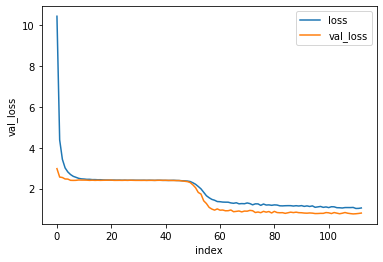

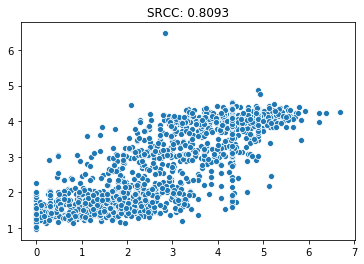

In [86]:
plot_model(history,model,X_test,y_test)